In [7]:
import random
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter
import random
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from PIL import Image

### Exploratory Data Analysis

In [8]:
# Set the style for plots
plt.style.use('fivethirtyeight')
sns.set_theme(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

In [12]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

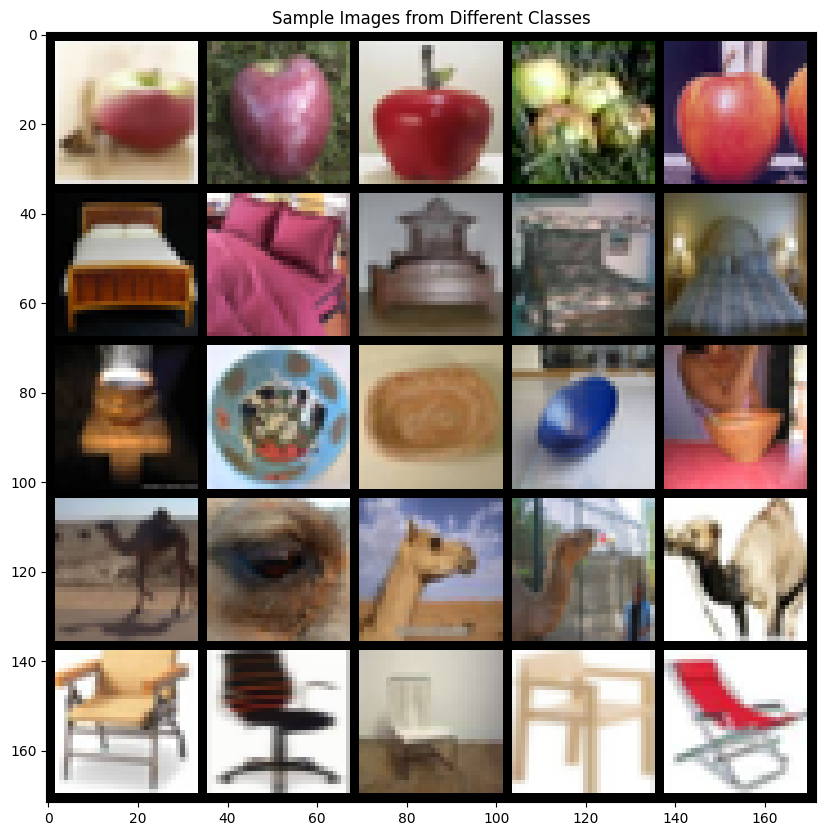

In [ ]:
# Select 5 classes, 5 images each
sample_images = []
sample_labels = []
for label in range(0, 25, 5):  # Sample from first 5 superclasses for diversity
    class_data = [img for img, l in trainset if l == label][:5]
    sample_images.extend(class_data)
    sample_labels.extend([label]*5)

# Display grid
grid = make_grid(sample_images, nrow=5)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.title('Sample Images from Different Classes')
plt.show()

In [13]:
# Create a DataFrame for easier analysis
train_data = []
for i in range(len(trainset)):
    img, label = trainset[i]
    train_data.append({
        'index': i,
        'label': label,
        'class': trainset.classes[label],
        'image': img
    })
train_df = pd.DataFrame(train_data)

test_data = []
for i in range(len(testset)):
    img, label = testset[i]
    test_data.append({
        'index': i,
        'label': label,
        'class': testset.classes[label],
        'image': img
    })
test_df = pd.DataFrame(test_data)

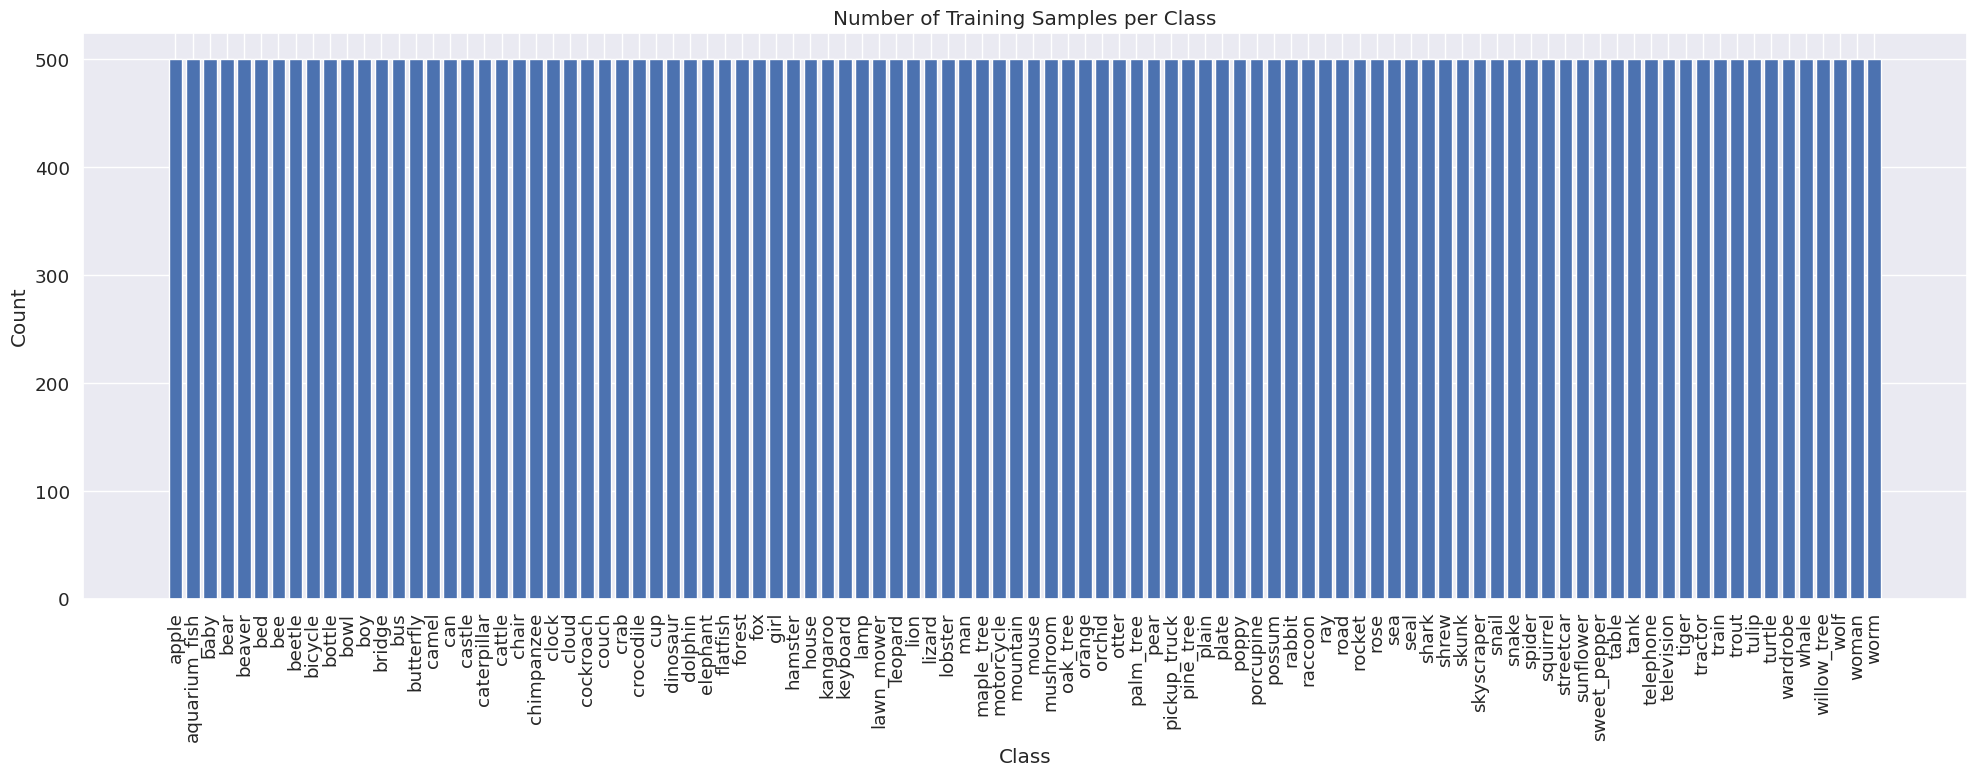

In [14]:
plt.figure(figsize=(20, 8))
    
# Count samples per class
class_counts = train_df['class'].value_counts().sort_index()

plt.bar(class_counts.index, class_counts.values)
plt.title('Number of Training Samples per Class')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

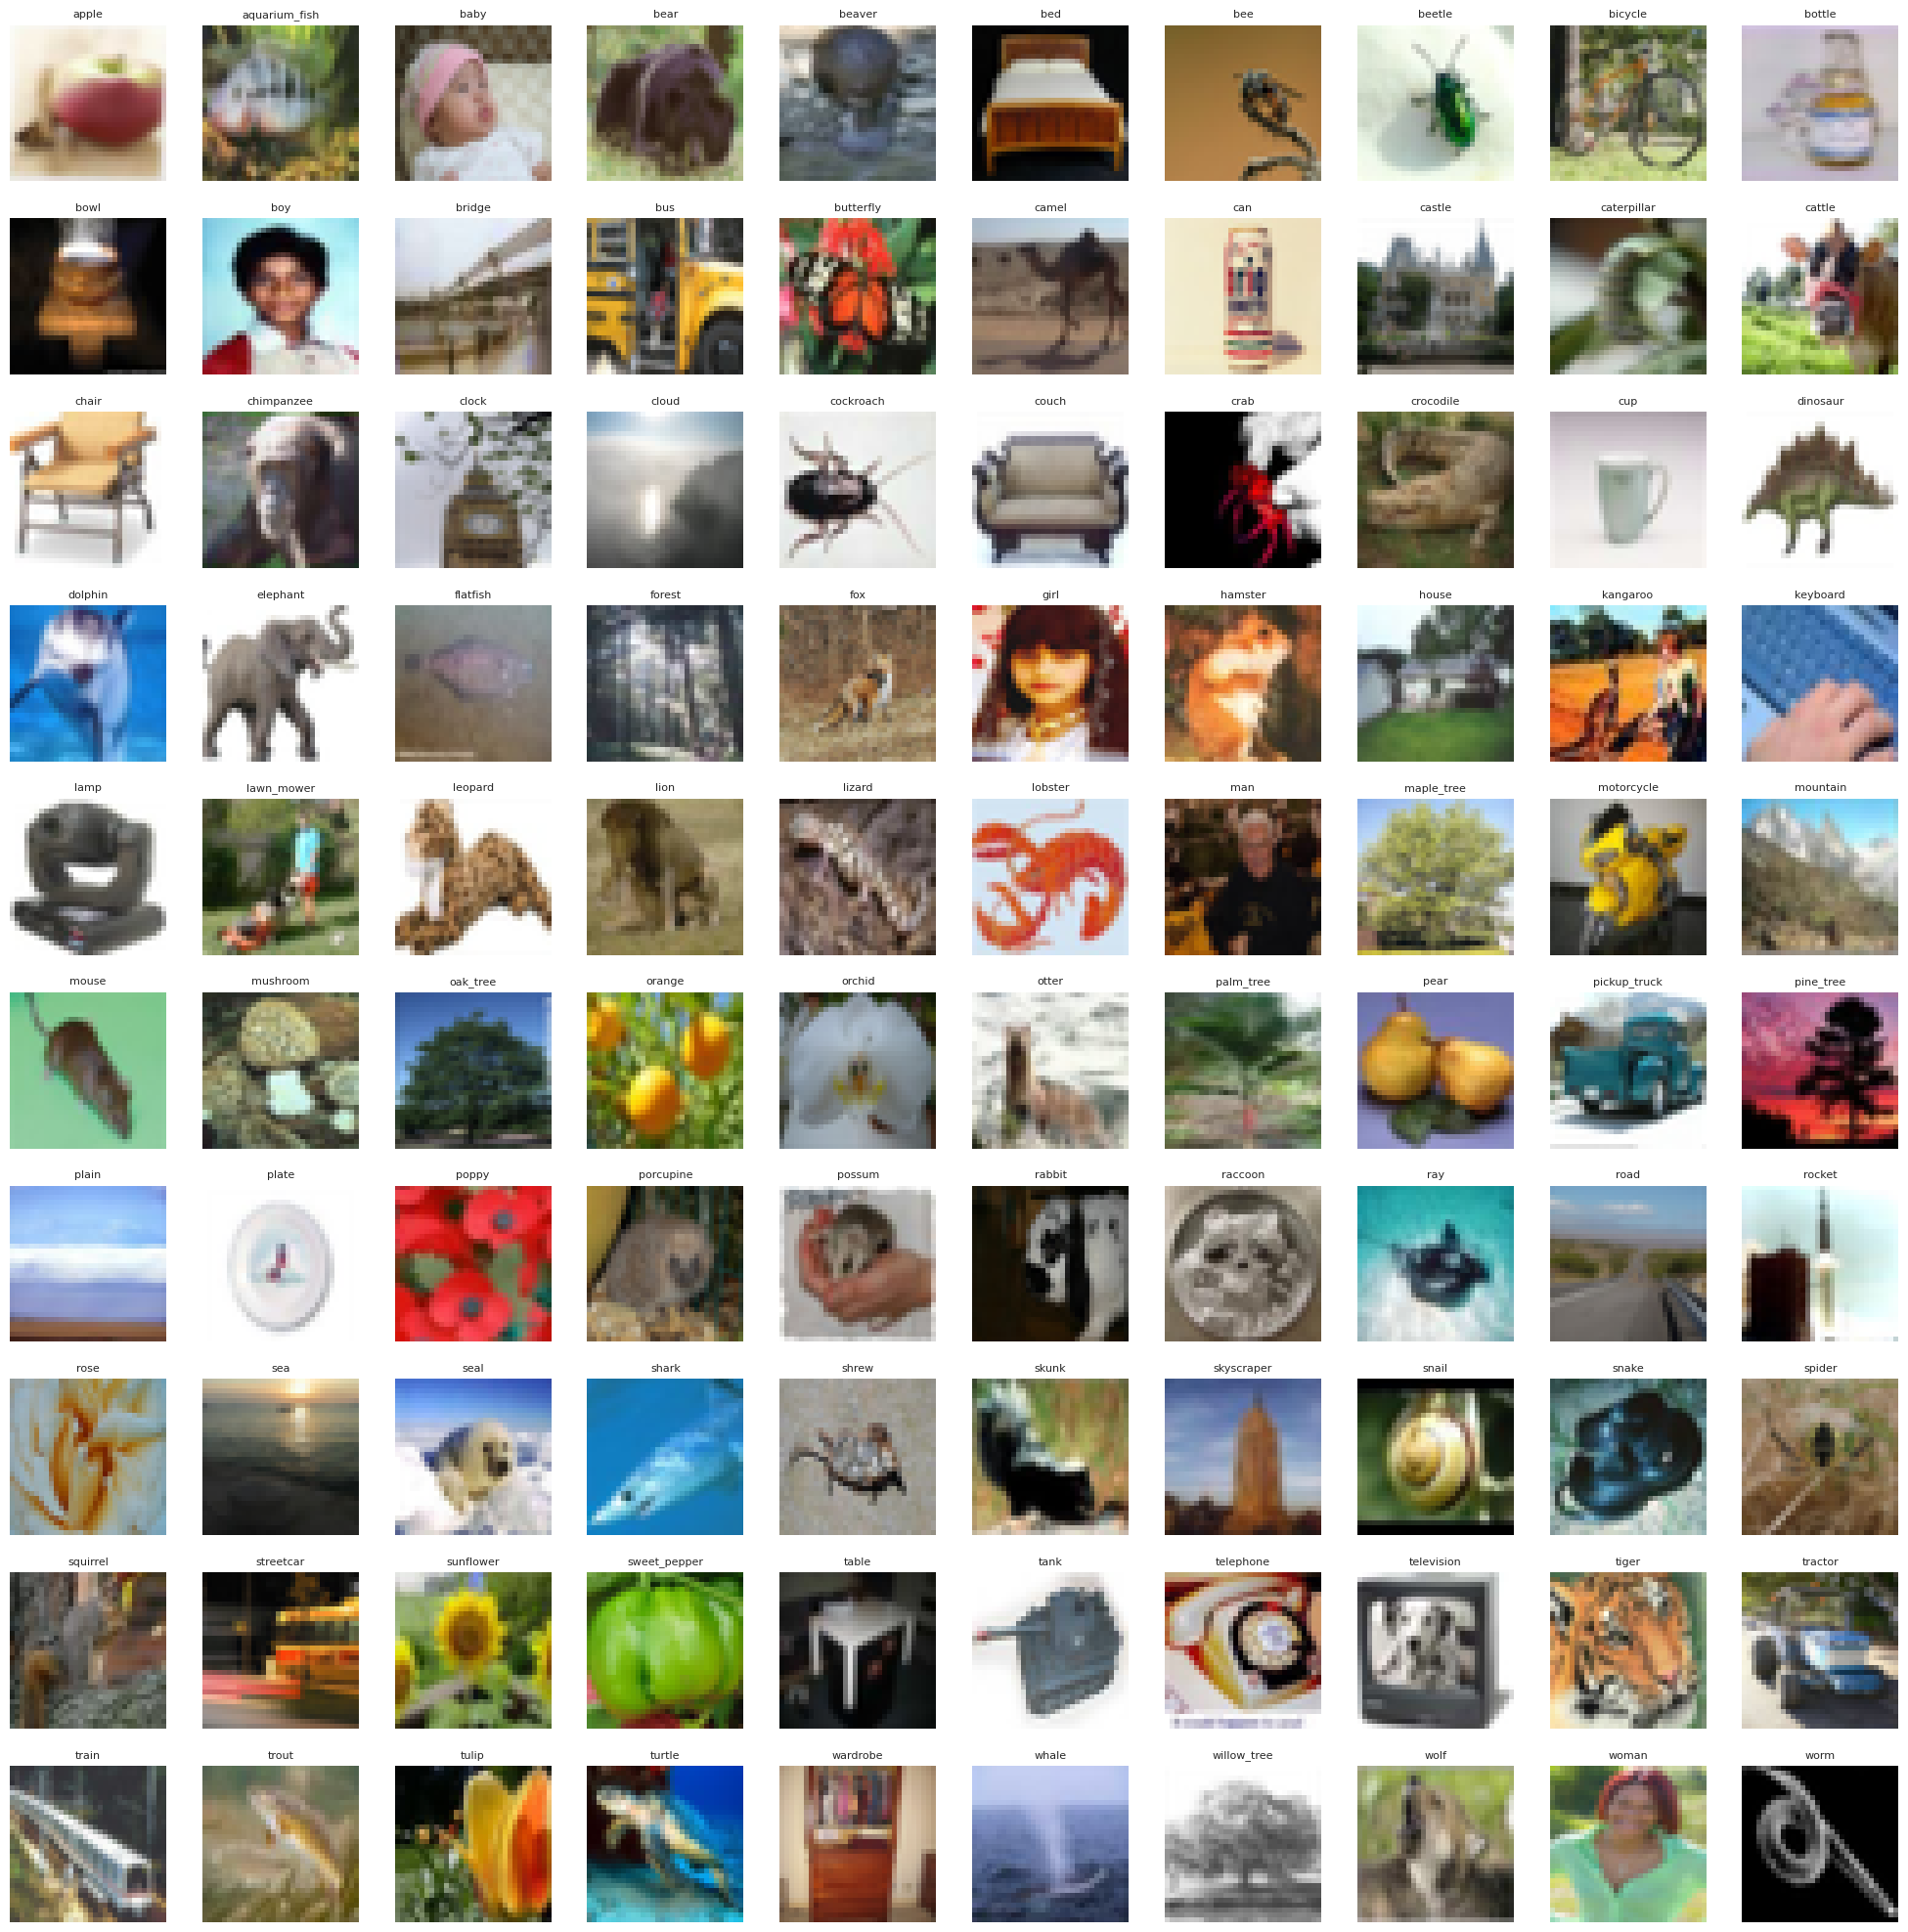

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    
for i, class_idx in enumerate(range(100)):
    # Get an image from this class
    img_idx = train_df[train_df['label'] == class_idx].index[0]
    img, _ = trainset[img_idx]
    
    # Plot in the corresponding subplot
    row, col = i // 10, i % 10
    axes[row, col].imshow(img.permute(1, 2, 0))
    axes[row, col].set_title(f"{trainset.classes[class_idx]}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

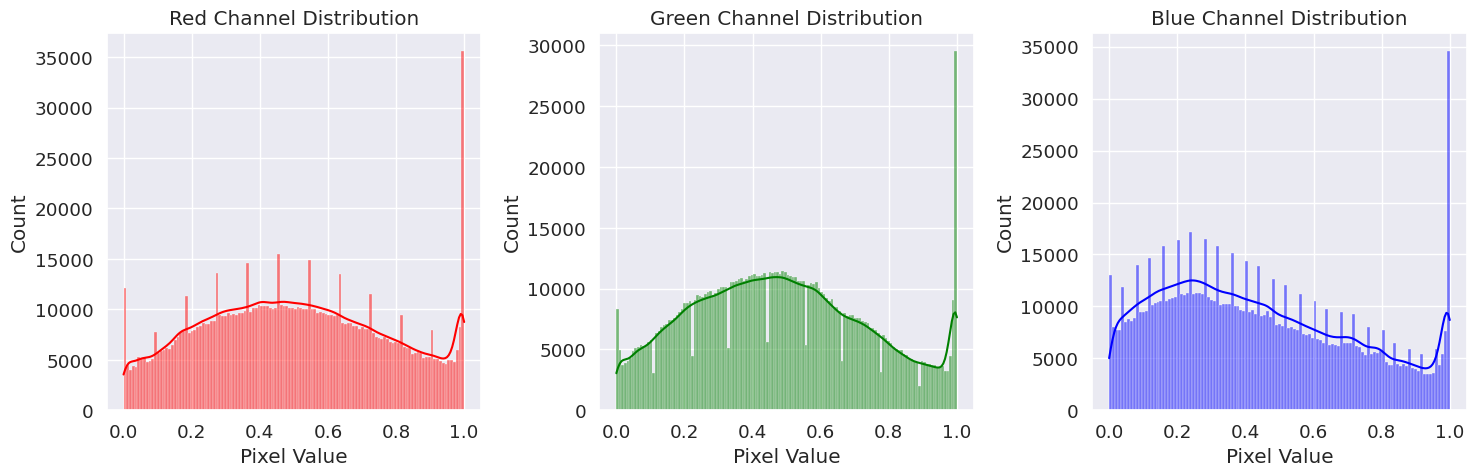

Channel means: [np.float32(0.50383985), np.float32(0.48364383), np.float32(0.43833345)]
Channel standard deviations: [np.float32(0.26831362), np.float32(0.25836906), np.float32(0.27846172)]


In [16]:
# Select random images
random_indices = random.sample(range(len(trainset)), 1000)
images = [trainset[i][0] for i in random_indices]

# Convert to numpy for analysis
images_np = torch.stack(images).numpy()

# Analyze pixel value distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(images_np[:, 0, :, :].flatten(), kde=True, color='red')
plt.title('Red Channel Distribution')
plt.xlabel('Pixel Value')

plt.subplot(1, 3, 2)
sns.histplot(images_np[:, 1, :, :].flatten(), kde=True, color='green')
plt.title('Green Channel Distribution')
plt.xlabel('Pixel Value')

plt.subplot(1, 3, 3)
sns.histplot(images_np[:, 2, :, :].flatten(), kde=True, color='blue')
plt.title('Blue Channel Distribution')
plt.xlabel('Pixel Value')

plt.tight_layout()
plt.savefig('pixel_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze mean and std for normalization
mean = [images_np[:, i, :, :].mean() for i in range(3)]
std = [images_np[:, i, :, :].std() for i in range(3)]

print(f"Channel means: {mean}")
print(f"Channel standard deviations: {std}")

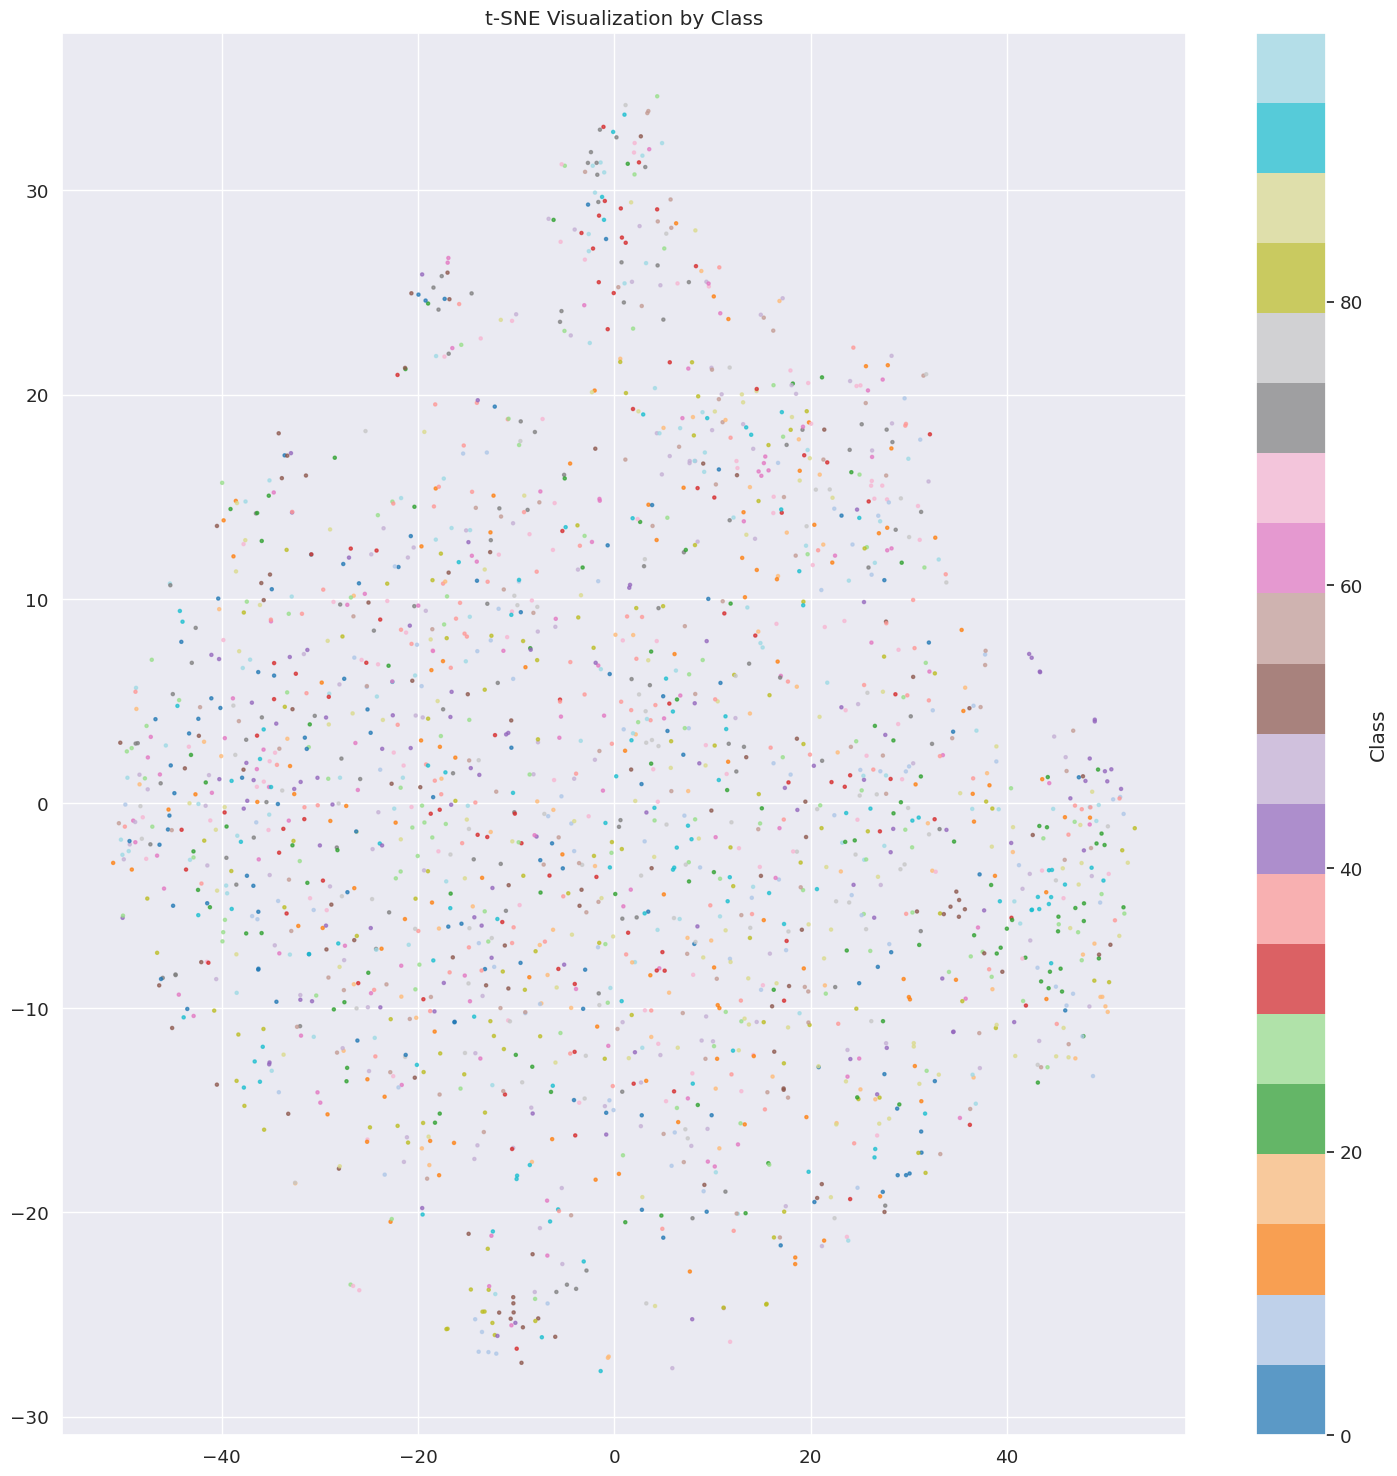

In [18]:
# Sample images for t-SNE (using all would be too slow)
indices = random.sample(range(len(trainset)), 2000)

# Extract features (flatten images)
features = []
labels = []

for idx in indices:
    img, label = trainset[idx]
    features.append(img.flatten().numpy())
    labels.append(label)

features = np.array(features)
labels = np.array(labels)

# Apply PCA first to reduce dimensions (speeds up t-SNE)
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_tsne = tsne.fit_transform(features_pca)

# Create plot
plt.figure(figsize=(15, 15))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='tab20', s=5, alpha=0.7)
plt.title('t-SNE Visualization by Class')
plt.colorbar(scatter, label='Class')

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

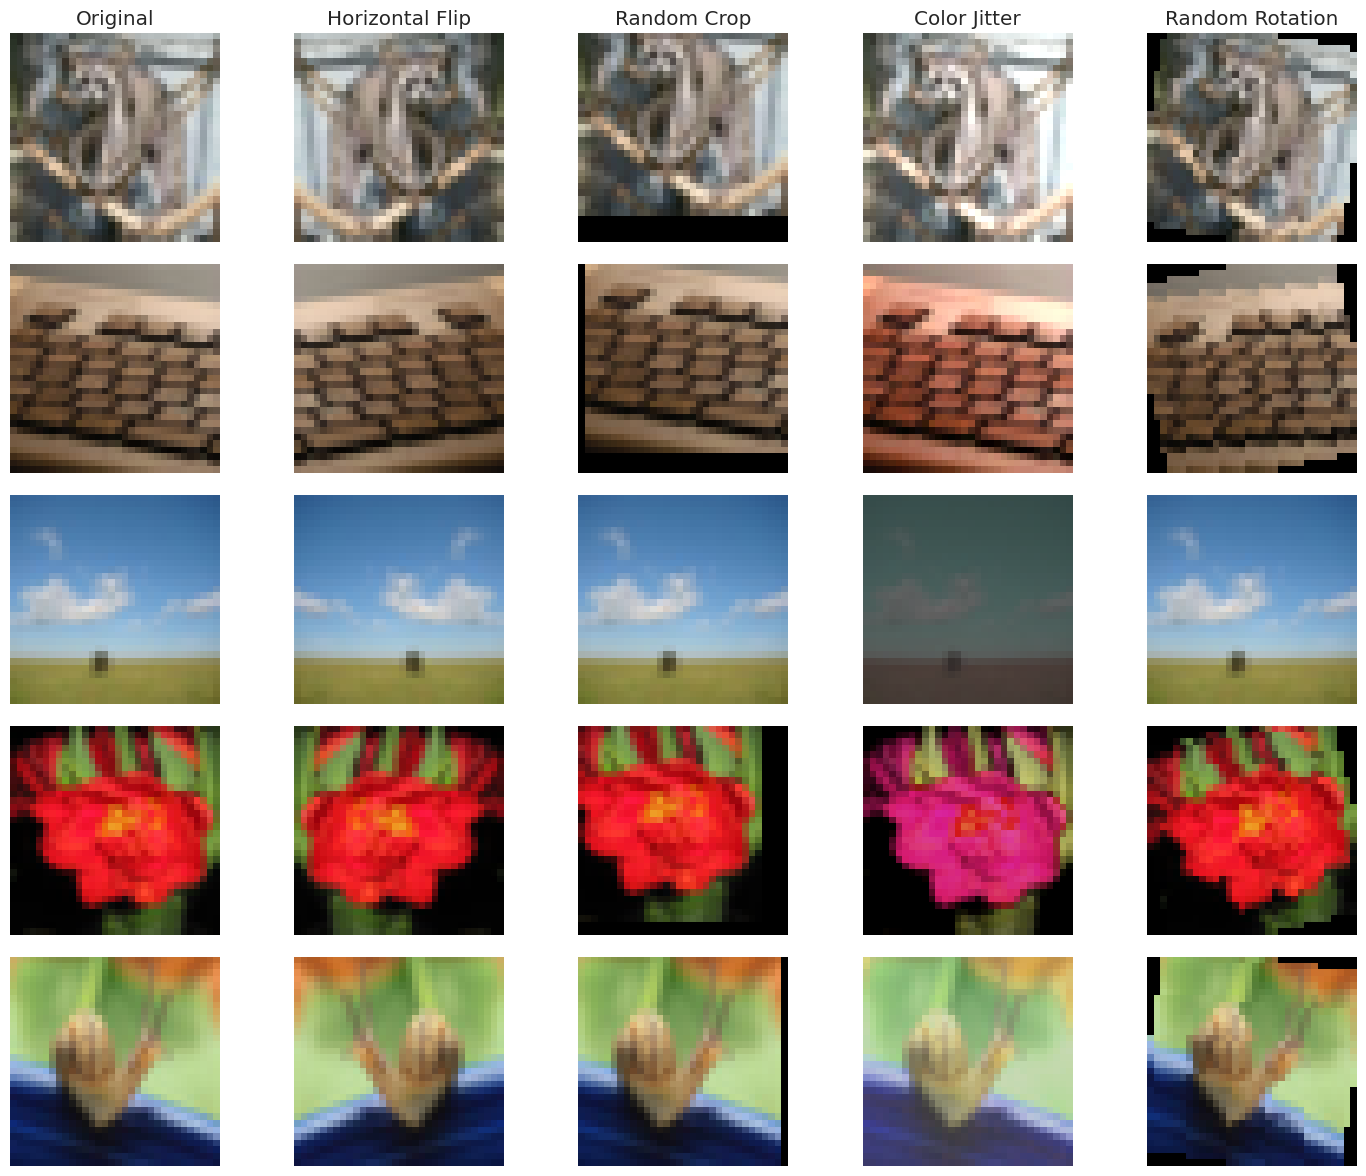

In [19]:
# Define augmentations
augmentations = {
    'Original': transforms.Compose([transforms.ToTensor()]),
    'Horizontal Flip': transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor()
    ]),
    'Random Crop': transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor()
    ]),
    'Color Jitter': transforms.Compose([
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.ToTensor()
    ]),
    'Random Rotation': transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ToTensor()
    ])
}

# Select a few random images
random_indices = random.sample(range(len(trainset)), 5)

# Create a grid to show augmentations
fig, axes = plt.subplots(5, len(augmentations), figsize=(15, 12))

for i, idx in enumerate(random_indices):
    img, label = trainset.data[idx], trainset.targets[idx]
    img_pil = Image.fromarray(img)
    
    for j, (aug_name, aug_transform) in enumerate(augmentations.items()):
        # Apply augmentation
        aug_img = aug_transform(img_pil)
        
        # Convert to numpy for display
        if isinstance(aug_img, torch.Tensor):
            aug_img = aug_img.permute(1, 2, 0).numpy()
        
        # Display
        axes[i, j].imshow(aug_img)
        if i == 0:
            axes[i, j].set_title(aug_name)
        axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=300, bbox_inches='tight')
plt.show()

### Training

In [2]:
# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# For validation/testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

In [ ]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [4]:
# Initialize ResNet18 model for CIFAR100 (100 classes)
model = models.resnet18(weights=None)  # Start from scratch for a true baseline

model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Adjust final fully connected layer for 100 classes
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model = model.cuda()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Step decay learning rate scheduler
def lr_schedule(epoch):
    if epoch < 80:
        return 1
    else:
        return 0.1

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_schedule)

In [7]:
# Training loop with tqdm
num_epochs = 200
best_acc = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in train_bar:
        inputs, labels = inputs.cuda(), labels.cuda()
        
        # Zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        train_bar.set_postfix({
            'loss': f'{train_loss/len(train_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    # Validation phase
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    test_bar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Test]')
    with torch.no_grad():
        for inputs, labels in test_bar:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            test_bar.set_postfix({
                'loss': f'{test_loss/len(test_bar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    # Update learning rate
    scheduler.step()
    
    # Save checkpoint if it's the best model so far
    if test_acc > best_acc:
        best_acc = test_acc
        checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_acc': best_acc,
        }
        torch.save(checkpoint, 'best_resnet18_cifar100.pth')
        print(f'Checkpoint saved! New best accuracy: {best_acc:.2f}%')
    
    # Print epoch summary
    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print(f"Training completed! Best accuracy: {best_acc:.2f}%")

Epoch 1/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.41it/s, loss=3.4276, acc=16.71%]


Checkpoint saved! New best accuracy: 16.71%
Epoch: 1/200 | Train Loss: 3.8906 | Train Acc: 10.21% | Test Loss: 3.4276 | Test Acc: 16.71%


Epoch 2/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s, loss=2.9022, acc=26.77%]


Checkpoint saved! New best accuracy: 26.77%
Epoch: 2/200 | Train Loss: 3.1868 | Train Acc: 21.13% | Test Loss: 2.9022 | Test Acc: 26.77%


Epoch 3/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.30it/s, loss=2.5165, acc=34.01%]


Checkpoint saved! New best accuracy: 34.01%
Epoch: 3/200 | Train Loss: 2.7583 | Train Acc: 29.11% | Test Loss: 2.5165 | Test Acc: 34.01%


Epoch 4/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.24it/s, loss=2.3425, acc=37.91%] 


Checkpoint saved! New best accuracy: 37.91%
Epoch: 4/200 | Train Loss: 2.4579 | Train Acc: 35.46% | Test Loss: 2.3425 | Test Acc: 37.91%


Epoch 5/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.35it/s, loss=2.2670, acc=40.32%]


Checkpoint saved! New best accuracy: 40.32%
Epoch: 5/200 | Train Loss: 2.2315 | Train Acc: 40.32% | Test Loss: 2.2670 | Test Acc: 40.32%


Epoch 6/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.05it/s, loss=2.0787, acc=43.91%]


Checkpoint saved! New best accuracy: 43.91%
Epoch: 6/200 | Train Loss: 2.0513 | Train Acc: 44.23% | Test Loss: 2.0787 | Test Acc: 43.91%


Epoch 7/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.58it/s, loss=2.0616, acc=45.54%]


Checkpoint saved! New best accuracy: 45.54%
Epoch: 7/200 | Train Loss: 1.9123 | Train Acc: 47.38% | Test Loss: 2.0616 | Test Acc: 45.54%


Epoch 8/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.44it/s, loss=1.8796, acc=50.23%]


Checkpoint saved! New best accuracy: 50.23%
Epoch: 8/200 | Train Loss: 1.7880 | Train Acc: 50.11% | Test Loss: 1.8796 | Test Acc: 50.23%


Epoch 9/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.09it/s, loss=1.8501, acc=50.48%]


Checkpoint saved! New best accuracy: 50.48%
Epoch: 9/200 | Train Loss: 1.6674 | Train Acc: 53.42% | Test Loss: 1.8501 | Test Acc: 50.48%


Epoch 10/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.15it/s, loss=1.8430, acc=51.18%]


Checkpoint saved! New best accuracy: 51.18%
Epoch: 10/200 | Train Loss: 1.5775 | Train Acc: 55.40% | Test Loss: 1.8430 | Test Acc: 51.18%


Epoch 11/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.02it/s, loss=1.7200, acc=53.23%] 


Checkpoint saved! New best accuracy: 53.23%
Epoch: 11/200 | Train Loss: 1.4815 | Train Acc: 57.65% | Test Loss: 1.7200 | Test Acc: 53.23%


Epoch 12/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.76it/s, loss=1.9118, acc=49.99%]


Epoch: 12/200 | Train Loss: 1.3952 | Train Acc: 59.92% | Test Loss: 1.9118 | Test Acc: 49.99%


Epoch 13/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.25it/s, loss=1.7619, acc=53.27%]


Checkpoint saved! New best accuracy: 53.27%
Epoch: 13/200 | Train Loss: 1.3379 | Train Acc: 61.47% | Test Loss: 1.7619 | Test Acc: 53.27%


Epoch 14/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.73it/s, loss=1.8308, acc=51.89%]


Epoch: 14/200 | Train Loss: 1.2710 | Train Acc: 62.97% | Test Loss: 1.8308 | Test Acc: 51.89%


Epoch 15/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.58it/s, loss=1.7426, acc=54.75%]


Checkpoint saved! New best accuracy: 54.75%
Epoch: 15/200 | Train Loss: 1.2170 | Train Acc: 64.27% | Test Loss: 1.7426 | Test Acc: 54.75%


Epoch 16/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.17it/s, loss=1.6902, acc=54.94%]


Checkpoint saved! New best accuracy: 54.94%
Epoch: 16/200 | Train Loss: 1.1605 | Train Acc: 65.60% | Test Loss: 1.6902 | Test Acc: 54.94%


Epoch 17/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.72it/s, loss=1.6659, acc=56.00%]


Checkpoint saved! New best accuracy: 56.00%
Epoch: 17/200 | Train Loss: 1.1104 | Train Acc: 66.96% | Test Loss: 1.6659 | Test Acc: 56.00%


Epoch 18/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 48.84it/s, loss=1.6885, acc=56.42%]


Checkpoint saved! New best accuracy: 56.42%
Epoch: 18/200 | Train Loss: 1.0488 | Train Acc: 68.58% | Test Loss: 1.6885 | Test Acc: 56.42%


Epoch 19/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.22it/s, loss=1.6803, acc=57.05%]


Checkpoint saved! New best accuracy: 57.05%
Epoch: 19/200 | Train Loss: 1.0067 | Train Acc: 69.71% | Test Loss: 1.6803 | Test Acc: 57.05%


Epoch 20/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 88.25it/s, loss=1.6623, acc=57.48%] 


Checkpoint saved! New best accuracy: 57.48%
Epoch: 20/200 | Train Loss: 0.9617 | Train Acc: 71.01% | Test Loss: 1.6623 | Test Acc: 57.48%


Epoch 21/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.22it/s, loss=1.6901, acc=56.73%]


Epoch: 21/200 | Train Loss: 0.9216 | Train Acc: 72.12% | Test Loss: 1.6901 | Test Acc: 56.73%


Epoch 22/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.24it/s, loss=1.6615, acc=57.59%]


Checkpoint saved! New best accuracy: 57.59%
Epoch: 22/200 | Train Loss: 0.8888 | Train Acc: 72.79% | Test Loss: 1.6615 | Test Acc: 57.59%


Epoch 23/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.15it/s, loss=1.7452, acc=56.68%]


Epoch: 23/200 | Train Loss: 0.8405 | Train Acc: 74.38% | Test Loss: 1.7452 | Test Acc: 56.68%


Epoch 24/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s, loss=1.6485, acc=58.66%]


Checkpoint saved! New best accuracy: 58.66%
Epoch: 24/200 | Train Loss: 0.8221 | Train Acc: 74.80% | Test Loss: 1.6485 | Test Acc: 58.66%


Epoch 25/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.69it/s, loss=1.6914, acc=58.10%]


Epoch: 25/200 | Train Loss: 0.7852 | Train Acc: 75.75% | Test Loss: 1.6914 | Test Acc: 58.10%


Epoch 26/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.39it/s, loss=1.6509, acc=59.39%]


Checkpoint saved! New best accuracy: 59.39%
Epoch: 26/200 | Train Loss: 0.7483 | Train Acc: 76.72% | Test Loss: 1.6509 | Test Acc: 59.39%


Epoch 27/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.50it/s, loss=1.6644, acc=59.25%]


Epoch: 27/200 | Train Loss: 0.7130 | Train Acc: 77.70% | Test Loss: 1.6644 | Test Acc: 59.25%


Epoch 28/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.37it/s, loss=1.7206, acc=59.02%]


Epoch: 28/200 | Train Loss: 0.6856 | Train Acc: 78.49% | Test Loss: 1.7206 | Test Acc: 59.02%


Epoch 29/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 86.93it/s, loss=1.7563, acc=58.48%] 


Epoch: 29/200 | Train Loss: 0.6685 | Train Acc: 78.87% | Test Loss: 1.7563 | Test Acc: 58.48%


Epoch 30/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.40it/s, loss=1.7711, acc=58.13%]


Epoch: 30/200 | Train Loss: 0.6409 | Train Acc: 79.77% | Test Loss: 1.7711 | Test Acc: 58.13%


Epoch 31/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.11it/s, loss=1.7132, acc=58.44%]


Epoch: 31/200 | Train Loss: 0.6205 | Train Acc: 80.42% | Test Loss: 1.7132 | Test Acc: 58.44%


Epoch 32/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 69.28it/s, loss=1.8226, acc=57.35%]


Epoch: 32/200 | Train Loss: 0.5946 | Train Acc: 81.10% | Test Loss: 1.8226 | Test Acc: 57.35%


Epoch 33/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.17it/s, loss=1.8173, acc=58.43%]


Epoch: 33/200 | Train Loss: 0.5814 | Train Acc: 81.63% | Test Loss: 1.8173 | Test Acc: 58.43%


Epoch 34/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.81it/s, loss=1.8441, acc=58.50%]


Epoch: 34/200 | Train Loss: 0.5545 | Train Acc: 82.52% | Test Loss: 1.8441 | Test Acc: 58.50%


Epoch 35/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.87it/s, loss=1.8844, acc=58.26%]


Epoch: 35/200 | Train Loss: 0.5349 | Train Acc: 83.04% | Test Loss: 1.8844 | Test Acc: 58.26%


Epoch 36/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.08it/s, loss=1.7619, acc=59.99%]


Checkpoint saved! New best accuracy: 59.99%
Epoch: 36/200 | Train Loss: 0.5277 | Train Acc: 83.12% | Test Loss: 1.7619 | Test Acc: 59.99%


Epoch 37/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.97it/s, loss=1.9298, acc=57.53%]


Epoch: 37/200 | Train Loss: 0.5130 | Train Acc: 83.60% | Test Loss: 1.9298 | Test Acc: 57.53%


Epoch 38/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.99it/s, loss=1.8885, acc=59.07%]


Epoch: 38/200 | Train Loss: 0.4916 | Train Acc: 84.40% | Test Loss: 1.8885 | Test Acc: 59.07%


Epoch 39/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.37it/s, loss=1.7779, acc=59.76%]


Epoch: 39/200 | Train Loss: 0.4801 | Train Acc: 84.80% | Test Loss: 1.7779 | Test Acc: 59.76%


Epoch 40/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.92it/s, loss=1.8961, acc=58.16%]


Epoch: 40/200 | Train Loss: 0.4635 | Train Acc: 85.07% | Test Loss: 1.8961 | Test Acc: 58.16%


Epoch 41/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.31it/s, loss=1.9116, acc=58.50%]


Epoch: 41/200 | Train Loss: 0.4627 | Train Acc: 85.21% | Test Loss: 1.9116 | Test Acc: 58.50%


Epoch 42/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.37it/s, loss=1.8789, acc=59.36%]


Epoch: 42/200 | Train Loss: 0.4567 | Train Acc: 85.16% | Test Loss: 1.8789 | Test Acc: 59.36%


Epoch 43/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.25it/s, loss=1.9007, acc=59.37%] 


Epoch: 43/200 | Train Loss: 0.4240 | Train Acc: 86.38% | Test Loss: 1.9007 | Test Acc: 59.37%


Epoch 44/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.30it/s, loss=1.8497, acc=59.74%]


Epoch: 44/200 | Train Loss: 0.4216 | Train Acc: 86.49% | Test Loss: 1.8497 | Test Acc: 59.74%


Epoch 45/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.22it/s, loss=1.9389, acc=58.94%]


Epoch: 45/200 | Train Loss: 0.4064 | Train Acc: 86.91% | Test Loss: 1.9389 | Test Acc: 58.94%


Epoch 46/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s, loss=1.8254, acc=60.29%]


Checkpoint saved! New best accuracy: 60.29%
Epoch: 46/200 | Train Loss: 0.4066 | Train Acc: 87.01% | Test Loss: 1.8254 | Test Acc: 60.29%


Epoch 47/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.69it/s, loss=1.8653, acc=60.09%]


Epoch: 47/200 | Train Loss: 0.3937 | Train Acc: 87.26% | Test Loss: 1.8653 | Test Acc: 60.09%


Epoch 48/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.68it/s, loss=1.8702, acc=59.68%]


Epoch: 48/200 | Train Loss: 0.4029 | Train Acc: 87.10% | Test Loss: 1.8702 | Test Acc: 59.68%


Epoch 49/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s, loss=2.0024, acc=57.83%]


Epoch: 49/200 | Train Loss: 0.3854 | Train Acc: 87.77% | Test Loss: 2.0024 | Test Acc: 57.83%


Epoch 50/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.53it/s, loss=1.9279, acc=58.37%]


Epoch: 50/200 | Train Loss: 0.3723 | Train Acc: 88.15% | Test Loss: 1.9279 | Test Acc: 58.37%


Epoch 51/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.51it/s, loss=1.9451, acc=59.08%] 


Epoch: 51/200 | Train Loss: 0.3630 | Train Acc: 88.38% | Test Loss: 1.9451 | Test Acc: 59.08%


Epoch 52/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.09it/s, loss=2.0451, acc=59.05%]


Epoch: 52/200 | Train Loss: 0.3749 | Train Acc: 87.87% | Test Loss: 2.0451 | Test Acc: 59.05%


Epoch 53/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.55it/s, loss=2.0253, acc=57.86%]


Epoch: 53/200 | Train Loss: 0.3684 | Train Acc: 87.99% | Test Loss: 2.0253 | Test Acc: 57.86%


Epoch 54/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.85it/s, loss=1.9625, acc=58.69%] 


Epoch: 54/200 | Train Loss: 0.3540 | Train Acc: 88.69% | Test Loss: 1.9625 | Test Acc: 58.69%


Epoch 55/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 48.57it/s, loss=1.8777, acc=60.19%]


Epoch: 55/200 | Train Loss: 0.3525 | Train Acc: 88.68% | Test Loss: 1.8777 | Test Acc: 60.19%


Epoch 56/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.14it/s, loss=2.0297, acc=57.72%]


Epoch: 56/200 | Train Loss: 0.3545 | Train Acc: 88.56% | Test Loss: 2.0297 | Test Acc: 57.72%


Epoch 57/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.00it/s, loss=1.9500, acc=59.30%]


Epoch: 57/200 | Train Loss: 0.3401 | Train Acc: 89.08% | Test Loss: 1.9500 | Test Acc: 59.30%


Epoch 58/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 43.66it/s, loss=2.0092, acc=58.31%]


Epoch: 58/200 | Train Loss: 0.3432 | Train Acc: 89.00% | Test Loss: 2.0092 | Test Acc: 58.31%


Epoch 59/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.28it/s, loss=2.0009, acc=58.98%]


Epoch: 59/200 | Train Loss: 0.3316 | Train Acc: 89.50% | Test Loss: 2.0009 | Test Acc: 58.98%


Epoch 60/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.88it/s, loss=1.9620, acc=58.82%] 


Epoch: 60/200 | Train Loss: 0.3314 | Train Acc: 89.40% | Test Loss: 1.9620 | Test Acc: 58.82%


Epoch 61/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.66it/s, loss=1.9940, acc=59.78%]


Epoch: 61/200 | Train Loss: 0.3218 | Train Acc: 89.81% | Test Loss: 1.9940 | Test Acc: 59.78%


Epoch 62/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.20it/s, loss=1.9690, acc=59.26%]


Epoch: 62/200 | Train Loss: 0.3330 | Train Acc: 89.30% | Test Loss: 1.9690 | Test Acc: 59.26%


Epoch 63/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.92it/s, loss=2.1335, acc=57.22%]


Epoch: 63/200 | Train Loss: 0.3380 | Train Acc: 89.24% | Test Loss: 2.1335 | Test Acc: 57.22%


Epoch 64/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.34it/s, loss=2.0184, acc=59.30%]


Epoch: 64/200 | Train Loss: 0.3202 | Train Acc: 89.72% | Test Loss: 2.0184 | Test Acc: 59.30%


Epoch 65/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.06it/s, loss=1.9643, acc=59.79%]


Epoch: 65/200 | Train Loss: 0.3089 | Train Acc: 90.09% | Test Loss: 1.9643 | Test Acc: 59.79%


Epoch 66/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.93it/s, loss=1.9983, acc=58.66%]


Epoch: 66/200 | Train Loss: 0.3175 | Train Acc: 89.88% | Test Loss: 1.9983 | Test Acc: 58.66%


Epoch 67/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 85.45it/s, loss=2.0637, acc=58.16%] 


Epoch: 67/200 | Train Loss: 0.3061 | Train Acc: 90.31% | Test Loss: 2.0637 | Test Acc: 58.16%


Epoch 68/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.46it/s, loss=1.9863, acc=59.38%]


Epoch: 68/200 | Train Loss: 0.3162 | Train Acc: 89.94% | Test Loss: 1.9863 | Test Acc: 59.38%


Epoch 69/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s, loss=1.9917, acc=58.07%]


Epoch: 69/200 | Train Loss: 0.3145 | Train Acc: 89.83% | Test Loss: 1.9917 | Test Acc: 58.07%


Epoch 70/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.77it/s, loss=2.0817, acc=58.27%]


Epoch: 70/200 | Train Loss: 0.3055 | Train Acc: 90.17% | Test Loss: 2.0817 | Test Acc: 58.27%


Epoch 71/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.42it/s, loss=1.9753, acc=59.09%]


Epoch: 71/200 | Train Loss: 0.3105 | Train Acc: 90.09% | Test Loss: 1.9753 | Test Acc: 59.09%


Epoch 72/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.85it/s, loss=1.9419, acc=59.96%]


Epoch: 72/200 | Train Loss: 0.3186 | Train Acc: 89.70% | Test Loss: 1.9419 | Test Acc: 59.96%


Epoch 73/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.97it/s, loss=2.0065, acc=58.75%]


Epoch: 73/200 | Train Loss: 0.2922 | Train Acc: 90.71% | Test Loss: 2.0065 | Test Acc: 58.75%


Epoch 74/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 42.34it/s, loss=1.9424, acc=59.56%]


Epoch: 74/200 | Train Loss: 0.2911 | Train Acc: 90.77% | Test Loss: 1.9424 | Test Acc: 59.56%


Epoch 75/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.86it/s, loss=2.0856, acc=57.96%]


Epoch: 75/200 | Train Loss: 0.2986 | Train Acc: 90.50% | Test Loss: 2.0856 | Test Acc: 57.96%


Epoch 76/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.81it/s, loss=1.9862, acc=59.46%] 


Epoch: 76/200 | Train Loss: 0.3063 | Train Acc: 90.30% | Test Loss: 1.9862 | Test Acc: 59.46%


Epoch 77/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.50it/s, loss=2.0724, acc=57.84%]


Epoch: 77/200 | Train Loss: 0.2973 | Train Acc: 90.43% | Test Loss: 2.0724 | Test Acc: 57.84%


Epoch 78/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.80it/s, loss=2.0806, acc=58.46%]


Epoch: 78/200 | Train Loss: 0.3033 | Train Acc: 90.30% | Test Loss: 2.0806 | Test Acc: 58.46%


Epoch 79/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.31it/s, loss=2.1884, acc=57.49%] 


Epoch: 79/200 | Train Loss: 0.2915 | Train Acc: 90.74% | Test Loss: 2.1884 | Test Acc: 57.49%


Epoch 80/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.26it/s, loss=2.0727, acc=58.56%]


Epoch: 80/200 | Train Loss: 0.2911 | Train Acc: 90.69% | Test Loss: 2.0727 | Test Acc: 58.56%


Epoch 81/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.50it/s, loss=1.6247, acc=65.35%]


Checkpoint saved! New best accuracy: 65.35%
Epoch: 81/200 | Train Loss: 0.1142 | Train Acc: 96.81% | Test Loss: 1.6247 | Test Acc: 65.35%


Epoch 82/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.11it/s, loss=1.6088, acc=65.99%]


Checkpoint saved! New best accuracy: 65.99%
Epoch: 82/200 | Train Loss: 0.0587 | Train Acc: 98.63% | Test Loss: 1.6088 | Test Acc: 65.99%


Epoch 83/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 42.80it/s, loss=1.6050, acc=66.47%]


Checkpoint saved! New best accuracy: 66.47%
Epoch: 83/200 | Train Loss: 0.0453 | Train Acc: 99.02% | Test Loss: 1.6050 | Test Acc: 66.47%


Epoch 84/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 66.97it/s, loss=1.5972, acc=66.59%]


Checkpoint saved! New best accuracy: 66.59%
Epoch: 84/200 | Train Loss: 0.0372 | Train Acc: 99.26% | Test Loss: 1.5972 | Test Acc: 66.59%


Epoch 85/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 83.58it/s, loss=1.6082, acc=66.45%] 


Epoch: 85/200 | Train Loss: 0.0316 | Train Acc: 99.41% | Test Loss: 1.6082 | Test Acc: 66.45%


Epoch 86/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.95it/s, loss=1.5991, acc=66.62%]


Checkpoint saved! New best accuracy: 66.62%
Epoch: 86/200 | Train Loss: 0.0292 | Train Acc: 99.46% | Test Loss: 1.5991 | Test Acc: 66.62%


Epoch 87/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.83it/s, loss=1.6144, acc=67.00%]


Checkpoint saved! New best accuracy: 67.00%
Epoch: 87/200 | Train Loss: 0.0250 | Train Acc: 99.59% | Test Loss: 1.6144 | Test Acc: 67.00%


Epoch 88/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.63it/s, loss=1.6086, acc=67.00%]


Epoch: 88/200 | Train Loss: 0.0234 | Train Acc: 99.57% | Test Loss: 1.6086 | Test Acc: 67.00%


Epoch 89/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.89it/s, loss=1.6083, acc=66.75%]


Epoch: 89/200 | Train Loss: 0.0212 | Train Acc: 99.65% | Test Loss: 1.6083 | Test Acc: 66.75%


Epoch 90/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.98it/s, loss=1.6063, acc=66.93%]


Epoch: 90/200 | Train Loss: 0.0204 | Train Acc: 99.68% | Test Loss: 1.6063 | Test Acc: 66.93%


Epoch 91/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.46it/s, loss=1.6121, acc=67.01%]


Checkpoint saved! New best accuracy: 67.01%
Epoch: 91/200 | Train Loss: 0.0189 | Train Acc: 99.70% | Test Loss: 1.6121 | Test Acc: 67.01%


Epoch 92/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.81it/s, loss=1.6085, acc=67.38%] 


Checkpoint saved! New best accuracy: 67.38%
Epoch: 92/200 | Train Loss: 0.0171 | Train Acc: 99.75% | Test Loss: 1.6085 | Test Acc: 67.38%


Epoch 93/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.39it/s, loss=1.6102, acc=67.13%]


Epoch: 93/200 | Train Loss: 0.0156 | Train Acc: 99.81% | Test Loss: 1.6102 | Test Acc: 67.13%


Epoch 94/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.81it/s, loss=1.5994, acc=67.15%]


Epoch: 94/200 | Train Loss: 0.0165 | Train Acc: 99.76% | Test Loss: 1.5994 | Test Acc: 67.15%


Epoch 95/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.27it/s, loss=1.6015, acc=67.08%] 


Epoch: 95/200 | Train Loss: 0.0150 | Train Acc: 99.80% | Test Loss: 1.6015 | Test Acc: 67.08%


Epoch 96/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.01it/s, loss=1.6029, acc=67.20%]


Epoch: 96/200 | Train Loss: 0.0148 | Train Acc: 99.75% | Test Loss: 1.6029 | Test Acc: 67.20%


Epoch 97/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s, loss=1.6024, acc=67.03%]


Epoch: 97/200 | Train Loss: 0.0134 | Train Acc: 99.82% | Test Loss: 1.6024 | Test Acc: 67.03%


Epoch 98/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.43it/s, loss=1.6043, acc=67.38%]


Epoch: 98/200 | Train Loss: 0.0134 | Train Acc: 99.83% | Test Loss: 1.6043 | Test Acc: 67.38%


Epoch 99/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.60it/s, loss=1.5983, acc=67.41%]


Checkpoint saved! New best accuracy: 67.41%
Epoch: 99/200 | Train Loss: 0.0130 | Train Acc: 99.83% | Test Loss: 1.5983 | Test Acc: 67.41%


Epoch 100/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.24it/s, loss=1.5959, acc=67.55%]


Checkpoint saved! New best accuracy: 67.55%
Epoch: 100/200 | Train Loss: 0.0122 | Train Acc: 99.84% | Test Loss: 1.5959 | Test Acc: 67.55%


Epoch 101/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.97it/s, loss=1.5942, acc=67.30%]


Epoch: 101/200 | Train Loss: 0.0120 | Train Acc: 99.85% | Test Loss: 1.5942 | Test Acc: 67.30%


Epoch 102/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.58it/s, loss=1.5969, acc=67.36%]


Epoch: 102/200 | Train Loss: 0.0111 | Train Acc: 99.85% | Test Loss: 1.5969 | Test Acc: 67.36%


Epoch 103/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 91.20it/s, loss=1.5932, acc=67.39%] 


Epoch: 103/200 | Train Loss: 0.0111 | Train Acc: 99.85% | Test Loss: 1.5932 | Test Acc: 67.39%


Epoch 104/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 81.41it/s, loss=1.5907, acc=67.44%] 


Epoch: 104/200 | Train Loss: 0.0111 | Train Acc: 99.85% | Test Loss: 1.5907 | Test Acc: 67.44%


Epoch 105/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.26it/s, loss=1.5845, acc=67.51%] 


Epoch: 105/200 | Train Loss: 0.0107 | Train Acc: 99.88% | Test Loss: 1.5845 | Test Acc: 67.51%


Epoch 106/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.59it/s, loss=1.5880, acc=67.59%] 


Checkpoint saved! New best accuracy: 67.59%
Epoch: 106/200 | Train Loss: 0.0104 | Train Acc: 99.85% | Test Loss: 1.5880 | Test Acc: 67.59%


Epoch 107/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 80.71it/s, loss=1.5791, acc=67.69%] 


Checkpoint saved! New best accuracy: 67.69%
Epoch: 107/200 | Train Loss: 0.0103 | Train Acc: 99.84% | Test Loss: 1.5791 | Test Acc: 67.69%


Epoch 108/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 87.09it/s, loss=1.5704, acc=67.43%] 


Epoch: 108/200 | Train Loss: 0.0105 | Train Acc: 99.87% | Test Loss: 1.5704 | Test Acc: 67.43%


Epoch 109/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 79.03it/s, loss=1.5746, acc=67.67%] 


Epoch: 109/200 | Train Loss: 0.0095 | Train Acc: 99.87% | Test Loss: 1.5746 | Test Acc: 67.67%


Epoch 110/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.61it/s, loss=1.5762, acc=67.47%]


Epoch: 110/200 | Train Loss: 0.0091 | Train Acc: 99.91% | Test Loss: 1.5762 | Test Acc: 67.47%


Epoch 111/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.05it/s, loss=1.5729, acc=67.49%]


Epoch: 111/200 | Train Loss: 0.0094 | Train Acc: 99.87% | Test Loss: 1.5729 | Test Acc: 67.49%


Epoch 112/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.12it/s, loss=1.5697, acc=67.77%]


Checkpoint saved! New best accuracy: 67.77%
Epoch: 112/200 | Train Loss: 0.0089 | Train Acc: 99.92% | Test Loss: 1.5697 | Test Acc: 67.77%


Epoch 113/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.38it/s, loss=1.5687, acc=67.56%]


Epoch: 113/200 | Train Loss: 0.0089 | Train Acc: 99.91% | Test Loss: 1.5687 | Test Acc: 67.56%


Epoch 114/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.12it/s, loss=1.5649, acc=67.65%]


Epoch: 114/200 | Train Loss: 0.0086 | Train Acc: 99.93% | Test Loss: 1.5649 | Test Acc: 67.65%


Epoch 115/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.77it/s, loss=1.5674, acc=67.53%]


Epoch: 115/200 | Train Loss: 0.0084 | Train Acc: 99.91% | Test Loss: 1.5674 | Test Acc: 67.53%


Epoch 116/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 45.53it/s, loss=1.5587, acc=67.49%]


Epoch: 116/200 | Train Loss: 0.0090 | Train Acc: 99.90% | Test Loss: 1.5587 | Test Acc: 67.49%


Epoch 117/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.69it/s, loss=1.5628, acc=67.56%]


Epoch: 117/200 | Train Loss: 0.0085 | Train Acc: 99.91% | Test Loss: 1.5628 | Test Acc: 67.56%


Epoch 118/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 72.20it/s, loss=1.5525, acc=67.69%]


Epoch: 118/200 | Train Loss: 0.0082 | Train Acc: 99.91% | Test Loss: 1.5525 | Test Acc: 67.69%


Epoch 119/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.57it/s, loss=1.5487, acc=67.93%]


Checkpoint saved! New best accuracy: 67.93%
Epoch: 119/200 | Train Loss: 0.0082 | Train Acc: 99.91% | Test Loss: 1.5487 | Test Acc: 67.93%


Epoch 120/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.28it/s, loss=1.5505, acc=67.71%]


Epoch: 120/200 | Train Loss: 0.0080 | Train Acc: 99.90% | Test Loss: 1.5505 | Test Acc: 67.71%


Epoch 121/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.42it/s, loss=1.5457, acc=67.80%]


Epoch: 121/200 | Train Loss: 0.0081 | Train Acc: 99.91% | Test Loss: 1.5457 | Test Acc: 67.80%


Epoch 122/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.59it/s, loss=1.5466, acc=67.78%]


Epoch: 122/200 | Train Loss: 0.0077 | Train Acc: 99.92% | Test Loss: 1.5466 | Test Acc: 67.78%


Epoch 123/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 45.09it/s, loss=1.5418, acc=67.95%]


Checkpoint saved! New best accuracy: 67.95%
Epoch: 123/200 | Train Loss: 0.0076 | Train Acc: 99.93% | Test Loss: 1.5418 | Test Acc: 67.95%


Epoch 124/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.11it/s, loss=1.5317, acc=67.89%]


Epoch: 124/200 | Train Loss: 0.0077 | Train Acc: 99.93% | Test Loss: 1.5317 | Test Acc: 67.89%


Epoch 125/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.88it/s, loss=1.5376, acc=67.53%]


Epoch: 125/200 | Train Loss: 0.0075 | Train Acc: 99.93% | Test Loss: 1.5376 | Test Acc: 67.53%


Epoch 126/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.33it/s, loss=1.5328, acc=67.95%]


Epoch: 126/200 | Train Loss: 0.0077 | Train Acc: 99.92% | Test Loss: 1.5328 | Test Acc: 67.95%


Epoch 127/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 42.33it/s, loss=1.5362, acc=67.55%]


Epoch: 127/200 | Train Loss: 0.0076 | Train Acc: 99.92% | Test Loss: 1.5362 | Test Acc: 67.55%


Epoch 128/200 [Test]: 100%|██████████| 79/79 [00:02<00:00, 38.74it/s, loss=1.5331, acc=67.71%]


Epoch: 128/200 | Train Loss: 0.0073 | Train Acc: 99.93% | Test Loss: 1.5331 | Test Acc: 67.71%


Epoch 129/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.41it/s, loss=1.5289, acc=67.73%] 


Epoch: 129/200 | Train Loss: 0.0070 | Train Acc: 99.93% | Test Loss: 1.5289 | Test Acc: 67.73%


Epoch 130/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.70it/s, loss=1.5367, acc=67.82%]


Epoch: 130/200 | Train Loss: 0.0073 | Train Acc: 99.92% | Test Loss: 1.5367 | Test Acc: 67.82%


Epoch 131/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.47it/s, loss=1.5294, acc=67.51%] 


Epoch: 131/200 | Train Loss: 0.0067 | Train Acc: 99.95% | Test Loss: 1.5294 | Test Acc: 67.51%


Epoch 132/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 48.34it/s, loss=1.5201, acc=67.65%]


Epoch: 132/200 | Train Loss: 0.0069 | Train Acc: 99.94% | Test Loss: 1.5201 | Test Acc: 67.65%


Epoch 133/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 41.56it/s, loss=1.5240, acc=67.84%]


Epoch: 133/200 | Train Loss: 0.0067 | Train Acc: 99.93% | Test Loss: 1.5240 | Test Acc: 67.84%


Epoch 134/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.86it/s, loss=1.5206, acc=68.03%] 


Checkpoint saved! New best accuracy: 68.03%
Epoch: 134/200 | Train Loss: 0.0071 | Train Acc: 99.93% | Test Loss: 1.5206 | Test Acc: 68.03%


Epoch 135/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.86it/s, loss=1.5180, acc=67.90%] 


Epoch: 135/200 | Train Loss: 0.0072 | Train Acc: 99.92% | Test Loss: 1.5180 | Test Acc: 67.90%


Epoch 136/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.13it/s, loss=1.5160, acc=67.84%]


Epoch: 136/200 | Train Loss: 0.0069 | Train Acc: 99.93% | Test Loss: 1.5160 | Test Acc: 67.84%


Epoch 137/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.90it/s, loss=1.5147, acc=67.76%]


Epoch: 137/200 | Train Loss: 0.0064 | Train Acc: 99.93% | Test Loss: 1.5147 | Test Acc: 67.76%


Epoch 138/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.05it/s, loss=1.5123, acc=67.92%]


Epoch: 138/200 | Train Loss: 0.0068 | Train Acc: 99.95% | Test Loss: 1.5123 | Test Acc: 67.92%


Epoch 139/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.74it/s, loss=1.5096, acc=67.96%]


Epoch: 139/200 | Train Loss: 0.0066 | Train Acc: 99.94% | Test Loss: 1.5096 | Test Acc: 67.96%


Epoch 140/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 46.94it/s, loss=1.5044, acc=67.96%]


Epoch: 140/200 | Train Loss: 0.0068 | Train Acc: 99.93% | Test Loss: 1.5044 | Test Acc: 67.96%


Epoch 141/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 49.36it/s, loss=1.5073, acc=67.80%]


Epoch: 141/200 | Train Loss: 0.0067 | Train Acc: 99.94% | Test Loss: 1.5073 | Test Acc: 67.80%


Epoch 142/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.85it/s, loss=1.5006, acc=68.04%]


Checkpoint saved! New best accuracy: 68.04%
Epoch: 142/200 | Train Loss: 0.0065 | Train Acc: 99.94% | Test Loss: 1.5006 | Test Acc: 68.04%


Epoch 143/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 88.88it/s, loss=1.5012, acc=67.94%] 


Epoch: 143/200 | Train Loss: 0.0062 | Train Acc: 99.94% | Test Loss: 1.5012 | Test Acc: 67.94%


Epoch 144/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.87it/s, loss=1.4965, acc=67.99%]


Epoch: 144/200 | Train Loss: 0.0066 | Train Acc: 99.94% | Test Loss: 1.4965 | Test Acc: 67.99%


Epoch 145/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.40it/s, loss=1.4997, acc=68.10%]


Checkpoint saved! New best accuracy: 68.10%
Epoch: 145/200 | Train Loss: 0.0065 | Train Acc: 99.94% | Test Loss: 1.4997 | Test Acc: 68.10%


Epoch 146/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.50it/s, loss=1.4897, acc=67.91%]


Epoch: 146/200 | Train Loss: 0.0062 | Train Acc: 99.95% | Test Loss: 1.4897 | Test Acc: 67.91%


Epoch 147/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 47.33it/s, loss=1.4986, acc=67.79%]


Epoch: 147/200 | Train Loss: 0.0064 | Train Acc: 99.94% | Test Loss: 1.4986 | Test Acc: 67.79%


Epoch 148/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.21it/s, loss=1.4947, acc=68.04%]


Epoch: 148/200 | Train Loss: 0.0063 | Train Acc: 99.94% | Test Loss: 1.4947 | Test Acc: 68.04%


Epoch 149/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.73it/s, loss=1.4913, acc=68.10%]


Epoch: 149/200 | Train Loss: 0.0063 | Train Acc: 99.93% | Test Loss: 1.4913 | Test Acc: 68.10%


Epoch 150/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 78.02it/s, loss=1.4923, acc=67.94%] 


Epoch: 150/200 | Train Loss: 0.0062 | Train Acc: 99.94% | Test Loss: 1.4923 | Test Acc: 67.94%


Epoch 151/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.81it/s, loss=1.4871, acc=67.75%]


Epoch: 151/200 | Train Loss: 0.0063 | Train Acc: 99.94% | Test Loss: 1.4871 | Test Acc: 67.75%


Epoch 152/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 48.60it/s, loss=1.4879, acc=68.13%]


Checkpoint saved! New best accuracy: 68.13%
Epoch: 152/200 | Train Loss: 0.0061 | Train Acc: 99.95% | Test Loss: 1.4879 | Test Acc: 68.13%


Epoch 153/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 42.43it/s, loss=1.4817, acc=68.20%]


Checkpoint saved! New best accuracy: 68.20%
Epoch: 153/200 | Train Loss: 0.0061 | Train Acc: 99.93% | Test Loss: 1.4817 | Test Acc: 68.20%


Epoch 154/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.12it/s, loss=1.4821, acc=68.17%]


Epoch: 154/200 | Train Loss: 0.0060 | Train Acc: 99.95% | Test Loss: 1.4821 | Test Acc: 68.17%


Epoch 155/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.25it/s, loss=1.4742, acc=68.05%]


Epoch: 155/200 | Train Loss: 0.0062 | Train Acc: 99.94% | Test Loss: 1.4742 | Test Acc: 68.05%


Epoch 156/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.19it/s, loss=1.4765, acc=67.93%]


Epoch: 156/200 | Train Loss: 0.0061 | Train Acc: 99.94% | Test Loss: 1.4765 | Test Acc: 67.93%


Epoch 157/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.30it/s, loss=1.4781, acc=68.16%]


Epoch: 157/200 | Train Loss: 0.0061 | Train Acc: 99.95% | Test Loss: 1.4781 | Test Acc: 68.16%


Epoch 158/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.30it/s, loss=1.4716, acc=68.09%]


Epoch: 158/200 | Train Loss: 0.0061 | Train Acc: 99.95% | Test Loss: 1.4716 | Test Acc: 68.09%


Epoch 159/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.03it/s, loss=1.4762, acc=68.02%]


Epoch: 159/200 | Train Loss: 0.0060 | Train Acc: 99.94% | Test Loss: 1.4762 | Test Acc: 68.02%


Epoch 160/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.73it/s, loss=1.4788, acc=68.14%]


Epoch: 160/200 | Train Loss: 0.0058 | Train Acc: 99.94% | Test Loss: 1.4788 | Test Acc: 68.14%


Epoch 161/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 63.03it/s, loss=1.4787, acc=67.92%]


Epoch: 161/200 | Train Loss: 0.0059 | Train Acc: 99.94% | Test Loss: 1.4787 | Test Acc: 67.92%


Epoch 162/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 54.93it/s, loss=1.4739, acc=68.03%]


Epoch: 162/200 | Train Loss: 0.0059 | Train Acc: 99.95% | Test Loss: 1.4739 | Test Acc: 68.03%


Epoch 163/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.33it/s, loss=1.4752, acc=68.32%]


Checkpoint saved! New best accuracy: 68.32%
Epoch: 163/200 | Train Loss: 0.0058 | Train Acc: 99.95% | Test Loss: 1.4752 | Test Acc: 68.32%


Epoch 164/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.16it/s, loss=1.4629, acc=68.09%]


Epoch: 164/200 | Train Loss: 0.0059 | Train Acc: 99.94% | Test Loss: 1.4629 | Test Acc: 68.09%


Epoch 165/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 77.68it/s, loss=1.4628, acc=68.15%] 


Epoch: 165/200 | Train Loss: 0.0057 | Train Acc: 99.95% | Test Loss: 1.4628 | Test Acc: 68.15%


Epoch 166/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.22it/s, loss=1.4561, acc=68.20%]


Epoch: 166/200 | Train Loss: 0.0060 | Train Acc: 99.94% | Test Loss: 1.4561 | Test Acc: 68.20%


Epoch 167/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.17it/s, loss=1.4594, acc=68.25%]


Epoch: 167/200 | Train Loss: 0.0057 | Train Acc: 99.94% | Test Loss: 1.4594 | Test Acc: 68.25%


Epoch 168/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.12it/s, loss=1.4658, acc=68.28%]


Epoch: 168/200 | Train Loss: 0.0058 | Train Acc: 99.95% | Test Loss: 1.4658 | Test Acc: 68.28%


Epoch 169/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.10it/s, loss=1.4564, acc=68.21%]


Epoch: 169/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4564 | Test Acc: 68.21%


Epoch 170/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.28it/s, loss=1.4547, acc=68.15%]


Epoch: 170/200 | Train Loss: 0.0057 | Train Acc: 99.95% | Test Loss: 1.4547 | Test Acc: 68.15%


Epoch 171/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.14it/s, loss=1.4576, acc=68.24%]


Epoch: 171/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4576 | Test Acc: 68.24%


Epoch 172/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.65it/s, loss=1.4506, acc=68.34%]


Checkpoint saved! New best accuracy: 68.34%
Epoch: 172/200 | Train Loss: 0.0058 | Train Acc: 99.94% | Test Loss: 1.4506 | Test Acc: 68.34%


Epoch 173/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.28it/s, loss=1.4545, acc=68.23%]


Epoch: 173/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4545 | Test Acc: 68.23%


Epoch 174/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 51.45it/s, loss=1.4514, acc=68.24%]


Epoch: 174/200 | Train Loss: 0.0055 | Train Acc: 99.95% | Test Loss: 1.4514 | Test Acc: 68.24%


Epoch 175/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 64.28it/s, loss=1.4569, acc=68.20%]


Epoch: 175/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4569 | Test Acc: 68.20%


Epoch 176/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 68.84it/s, loss=1.4482, acc=68.39%]


Checkpoint saved! New best accuracy: 68.39%
Epoch: 176/200 | Train Loss: 0.0058 | Train Acc: 99.94% | Test Loss: 1.4482 | Test Acc: 68.39%


Epoch 177/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.08it/s, loss=1.4488, acc=68.17%]


Epoch: 177/200 | Train Loss: 0.0054 | Train Acc: 99.95% | Test Loss: 1.4488 | Test Acc: 68.17%


Epoch 178/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.33it/s, loss=1.4487, acc=68.26%]


Epoch: 178/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4487 | Test Acc: 68.26%


Epoch 179/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.39it/s, loss=1.4489, acc=68.25%]


Epoch: 179/200 | Train Loss: 0.0054 | Train Acc: 99.95% | Test Loss: 1.4489 | Test Acc: 68.25%


Epoch 180/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.61it/s, loss=1.4521, acc=68.21%]


Epoch: 180/200 | Train Loss: 0.0053 | Train Acc: 99.95% | Test Loss: 1.4521 | Test Acc: 68.21%


Epoch 181/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.78it/s, loss=1.4525, acc=68.23%]


Epoch: 181/200 | Train Loss: 0.0054 | Train Acc: 99.96% | Test Loss: 1.4525 | Test Acc: 68.23%


Epoch 182/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.54it/s, loss=1.4468, acc=68.23%]


Epoch: 182/200 | Train Loss: 0.0056 | Train Acc: 99.94% | Test Loss: 1.4468 | Test Acc: 68.23%


Epoch 183/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 53.66it/s, loss=1.4474, acc=68.35%]


Epoch: 183/200 | Train Loss: 0.0056 | Train Acc: 99.95% | Test Loss: 1.4474 | Test Acc: 68.35%


Epoch 184/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 61.86it/s, loss=1.4478, acc=68.29%]


Epoch: 184/200 | Train Loss: 0.0054 | Train Acc: 99.95% | Test Loss: 1.4478 | Test Acc: 68.29%


Epoch 185/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 70.78it/s, loss=1.4438, acc=68.21%]


Epoch: 185/200 | Train Loss: 0.0053 | Train Acc: 99.96% | Test Loss: 1.4438 | Test Acc: 68.21%


Epoch 186/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 56.32it/s, loss=1.4425, acc=68.29%]


Epoch: 186/200 | Train Loss: 0.0053 | Train Acc: 99.95% | Test Loss: 1.4425 | Test Acc: 68.29%


Epoch 187/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 65.19it/s, loss=1.4370, acc=68.28%]


Epoch: 187/200 | Train Loss: 0.0052 | Train Acc: 99.94% | Test Loss: 1.4370 | Test Acc: 68.28%


Epoch 188/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 75.57it/s, loss=1.4399, acc=68.40%]


Checkpoint saved! New best accuracy: 68.40%
Epoch: 188/200 | Train Loss: 0.0055 | Train Acc: 99.95% | Test Loss: 1.4399 | Test Acc: 68.40%


Epoch 189/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 50.40it/s, loss=1.4454, acc=68.15%]


Epoch: 189/200 | Train Loss: 0.0056 | Train Acc: 99.94% | Test Loss: 1.4454 | Test Acc: 68.15%


Epoch 190/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 57.07it/s, loss=1.4377, acc=68.32%]


Epoch: 190/200 | Train Loss: 0.0055 | Train Acc: 99.95% | Test Loss: 1.4377 | Test Acc: 68.32%


Epoch 191/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s, loss=1.4403, acc=68.26%]


Epoch: 191/200 | Train Loss: 0.0053 | Train Acc: 99.95% | Test Loss: 1.4403 | Test Acc: 68.26%


Epoch 192/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 62.62it/s, loss=1.4362, acc=68.25%]


Epoch: 192/200 | Train Loss: 0.0054 | Train Acc: 99.95% | Test Loss: 1.4362 | Test Acc: 68.25%


Epoch 193/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 52.04it/s, loss=1.4318, acc=68.27%]


Epoch: 193/200 | Train Loss: 0.0053 | Train Acc: 99.95% | Test Loss: 1.4318 | Test Acc: 68.27%


Epoch 194/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.42it/s, loss=1.4280, acc=68.45%]


Checkpoint saved! New best accuracy: 68.45%
Epoch: 194/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.4280 | Test Acc: 68.45%


Epoch 195/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 58.70it/s, loss=1.4269, acc=68.37%]


Epoch: 195/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.4269 | Test Acc: 68.37%


Epoch 196/200 [Test]: 100%|██████████| 79/79 [00:00<00:00, 82.16it/s, loss=1.4304, acc=68.39%] 


Epoch: 196/200 | Train Loss: 0.0054 | Train Acc: 99.95% | Test Loss: 1.4304 | Test Acc: 68.39%


Epoch 197/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 55.18it/s, loss=1.4284, acc=68.57%]


Checkpoint saved! New best accuracy: 68.57%
Epoch: 197/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.4284 | Test Acc: 68.57%


Epoch 198/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 75.67it/s, loss=1.4248, acc=68.44%] 


Epoch: 198/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.4248 | Test Acc: 68.44%


Epoch 199/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 60.47it/s, loss=1.4323, acc=68.44%]


Epoch: 199/200 | Train Loss: 0.0051 | Train Acc: 99.96% | Test Loss: 1.4323 | Test Acc: 68.44%


Epoch 200/200 [Test]: 100%|██████████| 79/79 [00:01<00:00, 59.85it/s, loss=1.4282, acc=68.33%]

Epoch: 200/200 | Train Loss: 0.0049 | Train Acc: 99.97% | Test Loss: 1.4282 | Test Acc: 68.33%
Training completed! Best accuracy: 68.57%
